L'objectif de ce notebook est de regrouper les communes selons leurs catactéristiques socio économiques afin de constater si des groupes distincts peuvent être formés

Les critères de clustering sont:
* Immobilier:
> - Prix / m2
> - surfaces médianes
> - Tx evolution du prix / 10 ans
> - Nb de transactions
> - Tx de vacance locative
> - Tx de nouveaux logements x ans

* Démographie:
> - Densité population
> - Tx évolution population
> - Indicateur de jeuness: taux de population < x ans 

* Revenus:
> - Nombre de ménages fiscaux
> - Part de ménages fiscaux / total ménages
> - Part des ménages fiscaux imposés 
> - Médiane du revenu disponible (par unité de consommation)
> - Taux de pauvreté

* Emploi
> - Emploi total (salarié et non salarié) au lieu de travail 
> - Tx emploi (salarié et non salarié) sur le lieu de travail
> - part de l'emploi salarié au lieu de travail
> - Tx variation de l'emploi sur le lieu de travail
> - Taux d'activité
> - Taux de chômage
> - *sur le lieu de travail: Inclut tous les travailleurs exerçant leur activité dans une zone donnée, qu'ils y résident ou non.

Établissements:

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import altair as alt
import umap
import time

In [139]:
# df_sirene=pd.read_csv("../data/processed/sirene/idf/sirene_idf_duree_observation.csv")
# display(df_sirene.head())
# _agg={"duree_observation_etab": ("duree_observation_etab", "mean")}
# df_sirene[df_sirene["annee_observation_etab"].between(2011, 2015)].groupby("codeCommuneEtablissement").agg(**_agg)

In [140]:
df_stats_communes=pd.read_csv("../data/processed/base_cc_comparateur_csv/base_cc_comparateur.csv", sep=';', dtype={"CODGEO": str})
df_stats_dict=pd.read_csv("../data/processed/base_cc_comparateur_csv/meta_base_cc_comparateur.csv", sep=';')
ZE=pd.read_csv("../data/referentiels/zones_emloi.csv", sep=",", dtype={"CODGEO": str, "ZE2020": str})
df_communes=pd.read_csv("../data/referentiels/cog_ensemble_2023_csv/v_commune_2023.csv", sep=',', dtype={"COM": str, "REG": str}	)
df_regions=pd.read_csv("../data/referentiels/cog_ensemble_2023_csv/v_region_2023.csv", sep=',', dtype={"REG": str})
df_dvf=pd.read_csv("../data/processed/dfv_dataviz.csv.tar.gz", compression="gzip", dtype={"Code departement": str, "Code commune": str})
df_population_age=pd.read_csv("../data/referentiels/population-age-2020.csv", dtype={"Région":str, "Département": str, "Commune": str})
df_population_formation=pd.read_csv("../data/referentiels/base-cc-diplomes-formation-2021_csv/base-cc-diplomes-formation-2021.CSV", sep=";",dtype={"CODGEO": str})
df_population_formation_dict=pd.read_csv("../data/referentiels/base-cc-diplomes-formation-2021_csv/meta_base-cc-diplomes-formation-2021.CSV", sep=";")

regions=["idf", 'normandie']
df_sirene=pd.DataFrame([])
df_sirene_dvm=pd.DataFrame([])
for region in regions:
    _df_sirene=pd.read_csv(f"../data/processed/sirene/sirene_creations_net_{region}.csv", sep=',', dtype={"codeCommuneEtablissement": str})
    _df_dvm=pd.read_csv(f"../data/processed/sirene/sirene_dvm_{region}.csv", sep=',', dtype={"codeCommuneEtablissement": str})
    df_sirene_dvm=pd.concat([df_sirene_dvm, _df_dvm], axis=0)
    df_sirene=pd.concat([df_sirene, _df_sirene], axis=0)

print("info df_statas_communes:")
display(df_stats_communes.head())
display(df_stats_communes.info())

print('\n----------------------------\n')
print("info ZE")
display(ZE.head())
display(ZE.info())

print('\n----------------------------\n')
print("info df_communes")
display(df_communes.head())
display(df_communes.info())


print('\n----------------------------\n')
print("info df_regions")
display(df_regions.head())
display(df_regions.info())

print('\n----------------------------\n')
print("info df_sirene")
display(df_sirene.head())
display(df_sirene.info())

print('\n----------------------------\n')
print("info dvf")
display(df_dvf.head())
display(df_dvf.info())

print('\n----------------------------\n')
print("info df_sirene_dvm")
display(df_sirene_dvm.head())
display(df_sirene_dvm.info())


/tmp/ipykernel_196593/682350367.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_population_age=pd.read_csv("../data/referentiels/population-age-2020.csv", dtype={"Région":str, "Département": str, "Commune": str})


info df_statas_communes:


,CODGEO,P21_POP,P15_POP,SUPERF,NAIS1520,DECE1520,P21_MEN,NAISD22,DECESD22,P21_LOG,...,P21_ACT1564,ETTOT21,ETAZ21,ETBE21,ETFZ21,ETGU21,ETGZ21,ETOQ21,ETTEF121,ETTEFP1021
0,01001,832.0,767.0,15.95,52.0,33.0,341.234562,8.0,5.0,372.387494,...,417.591741,15.0,4.0,0.0,3.0,6.0,1.0,2.0,13.0,2.0
1,01002,267.0,241.0,9.15,18.0,8.0,115.722510,4.0,1.0,174.938672,...,130.225119,4.0,1.0,0.0,0.0,2.0,0.0,1.0,3.0,0.0
2,01004,14854.0,14127.0,24.60,1332.0,797.0,6932.839198,231.0,139.0,7846.021789,...,7118.709003,610.0,1.0,33.0,68.0,422.0,161.0,86.0,439.0,132.0
3,01005,1897.0,1619.0,15.92,111.0,50.0,794.753025,34.0,10.0,898.442947,...,987.970116,45.0,1.0,4.0,10.0,23.0,5.0,7.0,38.0,5.0
4,01006,113.0,109.0,5.88,6.0,6.0,56.500000,1.0,2.0,73.027778,...,50.552632,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34993 entries, 0 to 34992
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CODGEO         34993 non-null  object 
 1   P21_POP        34963 non-null  float64
 2   P15_POP        34963 non-null  float64
 3   SUPERF         34963 non-null  float64
 4   NAIS1520       34963 non-null  float64
 5   DECE1520       34963 non-null  float64
 6   P21_MEN        34960 non-null  float64
 7   NAISD22        34990 non-null  float64
 8   DECESD22       34990 non-null  float64
 9   P21_LOG        34960 non-null  float64
 10  P21_RP         34960 non-null  float64
 11  P21_RSECOCC    34960 non-null  float64
 12  P21_LOGVAC     34960 non-null  float64
 13  P21_RP_PROP    34960 non-null  float64
 14  NBMENFISC21    34909 non-null  object 
 15  PIMP21         34909 non-null  object 
 16  MED21          34909 non-null  object 
 17  TP6021         34909 non-null  object 
 18  P21_EM

None


----------------------------

info ZE


,CODGEO,LIBGEO,ZE2020,LIBZE2020,ZE2020_PARTIE_REG,DEP,REG
0,01001,L'Abergement-Clémenciat,8405,Bourg en Bresse,NaN,01,84
1,01002,L'Abergement-de-Varey,8405,Bourg en Bresse,NaN,01,84
2,01004,Ambérieu-en-Bugey,8405,Bourg en Bresse,NaN,01,84
3,01005,Ambérieux-en-Dombes,8434,Villefranche-sur-Saône,NaN,01,84
4,01006,Ambléon,8404,Belley,NaN,01,84


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34945 entries, 0 to 34944
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CODGEO             34945 non-null  object
 1   LIBGEO             34945 non-null  object
 2   ZE2020             34945 non-null  object
 3   LIBZE2020          34945 non-null  object
 4   ZE2020_PARTIE_REG  1687 non-null   object
 5   DEP                34945 non-null  object
 6   REG                34945 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.9+ MB


None


----------------------------

info df_communes


,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
0,COM,01001,84,01,01D,012,5,ABERGEMENT CLEMENCIAT,Abergement-Clémenciat,L'Abergement-Clémenciat,0108,NaN
1,COM,01002,84,01,01D,011,5,ABERGEMENT DE VAREY,Abergement-de-Varey,L'Abergement-de-Varey,0101,NaN
2,COM,01004,84,01,01D,011,1,AMBERIEU EN BUGEY,Ambérieu-en-Bugey,Ambérieu-en-Bugey,0101,NaN
3,COM,01005,84,01,01D,012,1,AMBERIEUX EN DOMBES,Ambérieux-en-Dombes,Ambérieux-en-Dombes,0122,NaN
4,COM,01006,84,01,01D,011,1,AMBLEON,Ambléon,Ambléon,0104,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37563 entries, 0 to 37562
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TYPECOM    37563 non-null  object 
 1   COM        37563 non-null  object 
 2   REG        34990 non-null  object 
 3   DEP        34990 non-null  object 
 4   CTCD       34990 non-null  object 
 5   ARR        34973 non-null  object 
 6   TNCC       37563 non-null  int64  
 7   NCC        37563 non-null  object 
 8   NCCENR     37563 non-null  object 
 9   LIBELLE    37563 non-null  object 
 10  CAN        34845 non-null  object 
 11  COMPARENT  2618 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 3.4+ MB


None


----------------------------

info df_regions


,REG,CHEFLIEU,TNCC,NCC,NCCENR,LIBELLE
0,01,97105,3,GUADELOUPE,Guadeloupe,Guadeloupe
1,02,97209,3,MARTINIQUE,Martinique,Martinique
2,03,97302,3,GUYANE,Guyane,Guyane
3,04,97411,0,LA REUNION,La Réunion,La Réunion
4,06,97608,0,MAYOTTE,Mayotte,Mayotte


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   REG       18 non-null     object
 1   CHEFLIEU  18 non-null     object
 2   TNCC      18 non-null     int64 
 3   NCC       18 non-null     object
 4   NCCENR    18 non-null     object
 5   LIBELLE   18 non-null     object
dtypes: int64(1), object(5)
memory usage: 996.0+ bytes


None


----------------------------

info df_sirene


,codeCommuneEtablissement,annee_mois,nb_etabl_crees,nb_etabl_fermes,nb_etabl_crees_net
0,75101,1990-01-01,3,0.0,3.0
1,75101,1990-02-01,2,1.0,1.0
2,75101,1990-03-01,2,0.0,2.0
3,75101,1990-04-01,2,0.0,2.0
4,75101,1990-05-01,3,0.0,3.0


<class 'pandas.core.frame.DataFrame'>
Index: 275379 entries, 0 to 112091
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   codeCommuneEtablissement  275379 non-null  object 
 1   annee_mois                275379 non-null  object 
 2   nb_etabl_crees            275379 non-null  int64  
 3   nb_etabl_fermes           275379 non-null  float64
 4   nb_etabl_crees_net        275379 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 12.6+ MB


None


----------------------------

info dvf


,dfv_dataviz.csv,annee,prix,Surface reelle bati,Code departement,Code commune,Commune,Code type local,Type local,Nombre pieces principales,prix_m2
0,Vente,2014.0,159000.0,158.0,14,14206,CROCY,1.0,Maison,6.0,1006.0
1,Vente,2014.0,159000.0,158.0,14,14206,CROCY,1.0,Maison,6.0,1006.0
2,Vente,2014.0,43000.0,16.0,14,14118,CAEN,2.0,Appartement,1.0,2688.0
3,Vente,2014.0,135600.0,88.0,14,14118,CAEN,2.0,Appartement,5.0,1541.0
4,Vente,2014.0,200000.0,110.0,14,14383,LOUVIGNY,1.0,Maison,5.0,1818.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152212 entries, 0 to 2152211
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   dfv_dataviz.csv            object 
 1   annee                      float64
 2   prix                       float64
 3   Surface reelle bati        float64
 4   Code departement           object 
 5   Code commune               object 
 6   Commune                    object 
 7   Code type local            float64
 8   Type local                 object 
 9   Nombre pieces principales  float64
 10  prix_m2                    float64
dtypes: float64(6), object(5)
memory usage: 180.6+ MB


None


----------------------------

info df_sirene_dvm


,codeCommuneEtablissement,indicateur_dvm
0,75101,0.990232
1,75102,1.027956
2,75103,1.063555
3,75104,0.995800
4,75105,1.057870


<class 'pandas.core.frame.DataFrame'>
Index: 3949 entries, 0 to 2650
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   codeCommuneEtablissement  3949 non-null   object 
 1   indicateur_dvm            3949 non-null   float64
dtypes: float64(1), object(1)
memory usage: 92.6+ KB


None

In [141]:
display(df_sirene_dvm['indicateur_dvm'].describe())
display(df_sirene_dvm[df_sirene_dvm["indicateur_dvm"]== np.inf].merge(df_stats_communes, left_on="codeCommuneEtablissement", right_on="CODGEO").drop(columns=df_stats_communes.columns.drop('P21_POP')))
df_sirene_dvm=df_sirene_dvm[df_sirene_dvm["indicateur_dvm"]!= np.inf]
display(df_sirene_dvm['indicateur_dvm'].describe())

/home/chougar/miniconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3949.000000
mean             inf
std              NaN
min         0.000000
25%         0.964981
50%         1.194118
75%         1.570964
max              inf
Name: indicateur_dvm, dtype: float64

,codeCommuneEtablissement,indicateur_dvm,P21_POP
0,14448,inf,66.0
1,14681,inf,145.0
2,27364,inf,186.0
3,76601,inf,233.0


count    3945.000000
mean        1.469960
std         1.392109
min         0.000000
25%         0.964415
50%         1.193548
75%         1.570151
max        28.000000
Name: indicateur_dvm, dtype: float64

In [118]:
object_columns = df_stats_communes.select_dtypes(include=['object']).columns
object_columns

Index(['CODGEO', 'NBMENFISC21', 'PIMP21', 'MED21', 'TP6021'], dtype='object')

#### clean num columns
replace "s" value by 0 (s means the com is not concerned ), for
* TP6021 (tx pauvreté)
* PIMP21	Part des ménages fiscaux imposés en 2021

In [119]:


cols_to_clean=['PIMP21', 'TP6021', "NBMENFISC21", "MED21"]
for col in cols_to_clean:
    df_stats_communes.loc[df_stats_communes[col]=="s", col]=0
    df_stats_communes.loc[df_stats_communes[col]=="nd", col]=0
    df_stats_communes.loc[:, col]= df_stats_communes[col].str.replace(",", ".")

# fill na
df_stats_communes.fillna(0, inplace=True)

# convert obj cols to num
for col in cols_to_clean:
    df_stats_communes[col]=df_stats_communes[col].astype(float)
df_stats_communes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34993 entries, 0 to 34992
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CODGEO         34993 non-null  object 
 1   P21_POP        34993 non-null  float64
 2   P15_POP        34993 non-null  float64
 3   SUPERF         34993 non-null  float64
 4   NAIS1520       34993 non-null  float64
 5   DECE1520       34993 non-null  float64
 6   P21_MEN        34993 non-null  float64
 7   NAISD22        34993 non-null  float64
 8   DECESD22       34993 non-null  float64
 9   P21_LOG        34993 non-null  float64
 10  P21_RP         34993 non-null  float64
 11  P21_RSECOCC    34993 non-null  float64
 12  P21_LOGVAC     34993 non-null  float64
 13  P21_RP_PROP    34993 non-null  float64
 14  NBMENFISC21    34993 non-null  float64
 15  PIMP21         34993 non-null  float64
 16  MED21          34993 non-null  float64
 17  TP6021         34993 non-null  float64
 18  P21_EM

In [120]:
# définition des variables
df_stats_dict= df_stats_dict[df_stats_dict["COD_VAR"]!="CODGEO"][["COD_VAR","LIB_VAR","LIB_VAR_LONG"]]
#df_stats_dict

In [121]:
# filtrer le df_stats_communes sur les 2 régions
codes_regions=["11", "28"]
display(df_regions[df_regions["REG"].isin(codes_regions)])
df_stats_communes=df_stats_communes.merge(df_communes, left_on='CODGEO', right_on='COM', how='left')
df_stats_communes.drop(columns=df_communes.columns.drop('REG'), inplace=True)
df_stats_communes=df_stats_communes[df_stats_communes["REG"].isin(codes_regions)].reset_index(drop=True)
df_stats_communes['REG'].value_counts()


,REG,CHEFLIEU,TNCC,NCC,NCCENR,LIBELLE
5,11,75056,1,ILE DE FRANCE,Île-de-France,Île-de-France
8,28,76540,0,NORMANDIE,Normandie,Normandie


REG
28    2651
11    1288
Name: count, dtype: int64

In [122]:
#### sélection des communes représentées dans les ZE
#df_stats_communes= df_stats_communes[df_stats_communes["P21_POP"]>250].reset_index()
print(f"total communes IDF+Normandie: {df_stats_communes.shape[0]}")
ZE_communes=ZE["CODGEO"].unique()
df_stats_communes= df_stats_communes[df_stats_communes["CODGEO"].isin(ZE_communes)]

print(f"communes IDF+Normandie dans les ZE: {df_stats_communes.shape[0]}")

total communes IDF+Normandie: 3939
communes IDF+Normandie dans les ZE: 3919


#### Récup les données créations établissements, prix immobilier et démographie (âge et formation)
**1. Indicateur pour la mesure du dynamisme des créations d'établ.**


* Calcul taux évol de créations d'établ entre les périodes 2012-2016 et 2017-2021

In [123]:
df_sirene["annee"]=pd.to_datetime(df_sirene["annee_mois"]).dt.year
df_sirene_tranche_n_1= pd.DataFrame(df_sirene[df_sirene["annee"].between(2012, 2016)].groupby("codeCommuneEtablissement")["nb_etabl_crees_net"].sum()).reset_index().rename(columns={"nb_etabl_crees_net": "nb_etabl_crees_net_tranche_n-1"})
df_sirene_tranche_n= pd.DataFrame(df_sirene[df_sirene["annee"].between(2017, 2021)].groupby("codeCommuneEtablissement")["nb_etabl_crees_net"].sum()).reset_index().rename(columns={"nb_etabl_crees_net": "nb_etabl_crees_net_tranche_n"})

df_sirene_tranches=df_sirene_tranche_n.merge(df_sirene_tranche_n_1, on="codeCommuneEtablissement", how="inner")

df_sirene_tranches["%_evol_creations_etabl"]=np.round((df_sirene_tranches['nb_etabl_crees_net_tranche_n']-df_sirene_tranches['nb_etabl_crees_net_tranche_n-1'])/df_sirene_tranches['nb_etabl_crees_net_tranche_n-1'],2)




* Ajout de l'indicateur au df_stats_communes

In [124]:
df_stats_communes= df_stats_communes.merge(df_sirene_tranches, left_on="CODGEO", right_on="codeCommuneEtablissement", how="left").drop(columns=df_sirene_tranches.columns.drop('%_evol_creations_etabl'))

* 2. Durée de vie moyenne des établissements / communes

In [125]:
df_stats_communes= df_stats_communes.merge(df_sirene_dvm, left_on="CODGEO", right_on="codeCommuneEtablissement", how="left").drop(columns=df_sirene_dvm.columns.drop('indicateur_dvm'))



* 3. Prix aux m2 et % de transactions

In [126]:
_agg={'prix_m2': ("prix_m2", "mean"), "nb_ventes": ("prix", "count")}
df_dvf_tranche_n_1_logements= df_dvf[(df_dvf["annee"].between(2014, 2017))& 
    (df_dvf["Code type local"].isin([1.0, 2.0]))].groupby(["Code commune"]).agg(**_agg).reset_index()

df_dvf_tranche_n_logements= df_dvf[(df_dvf["annee"].between(2018, 2021))& 
    (df_dvf["Code type local"].isin([1.0, 2.0]))].groupby(["Code commune"]).agg(**_agg).reset_index()

df_dvf_tranche_n_1_locaux= df_dvf[(df_dvf["annee"].between(2014, 2017))& 
    (df_dvf["Code type local"].isin([4.0]))].groupby(["Code commune"]).agg(**_agg).reset_index()

df_dvf_tranche_n_locaux= df_dvf[(df_dvf["annee"].between(2018, 2021))& 
    (df_dvf["Code type local"].isin([4.0]))].groupby(["Code commune"]).agg(**_agg).reset_index()

df_dvf_tranches_logements=df_dvf_tranche_n_logements.merge(df_dvf_tranche_n_1_logements, on='Code commune')
df_dvf_tranches_logements["%_evol_nb_ventes_logmts"]=np.round( (df_dvf_tranches_logements["nb_ventes_x"]-df_dvf_tranches_logements["nb_ventes_y"])/df_dvf_tranches_logements["nb_ventes_y"] ,2)
df_dvf_tranches_logements["%_evol_prix_m2_logmts"]=np.round( (df_dvf_tranches_logements["prix_m2_x"]-df_dvf_tranches_logements["prix_m2_y"])/df_dvf_tranches_logements["prix_m2_y"] ,2)
df_dvf_tranches_logements.rename(columns={"prix_m2_x": "prix_m2_logmts"} , inplace=True)

df_dvf_tranches_locaux=df_dvf_tranche_n_locaux.merge(df_dvf_tranche_n_1_locaux, on='Code commune')
df_dvf_tranches_locaux["%_evol_nb_ventes_locaux"]=np.round( (df_dvf_tranches_locaux["nb_ventes_x"]-df_dvf_tranches_locaux["nb_ventes_y"])/df_dvf_tranches_locaux["nb_ventes_y"] ,2)
df_dvf_tranches_locaux["%_evol_prix_m2_locaux"]=np.round( (df_dvf_tranches_locaux["prix_m2_x"]-df_dvf_tranches_locaux["prix_m2_y"])/df_dvf_tranches_locaux["prix_m2_y"] ,2)
df_dvf_tranches_locaux.rename(columns={"prix_m2_x": "prix_m2_locaux"}, inplace=True )
#df_dvf_tranches_locaux

* Ajout des indicateurs immo au df_stats_communes

In [127]:
df_stats_communes= df_stats_communes.merge(df_dvf_tranches_logements, left_on="CODGEO", right_on="Code commune", how="left").drop(
    columns=df_dvf_tranches_logements.columns.drop(['%_evol_nb_ventes_logmts', '%_evol_prix_m2_logmts', 'prix_m2_logmts']))

df_stats_communes= df_stats_communes.merge(df_dvf_tranches_locaux, left_on="CODGEO", right_on="Code commune", how="left").drop(
    columns=df_dvf_tranches_locaux.columns.drop(['%_evol_nb_ventes_locaux', '%_evol_prix_m2_locaux', 'prix_m2_locaux']))




In [144]:
df_sirene_dvm.shape

(3945, 2)

#### clean num columns
replace "s" value by 0 (s means the com is not concerned ), for
* TP6021 (tx pauvreté)
* PIMP21	Part des ménages fiscaux imposés en 2021

In [145]:


cols_to_clean=['PIMP21', 'TP6021', "NBMENFISC21", "MED21"]
for col in cols_to_clean:
    df_stats_communes.loc[df_stats_communes[col]=="s", col]=0
    df_stats_communes.loc[df_stats_communes[col]=="nd", col]=0
    df_stats_communes.loc[:, col]= df_stats_communes[col].str.replace(",", ".")

# fill na
df_stats_communes.fillna(0, inplace=True)

# convert obj cols to num
for col in cols_to_clean:
    df_stats_communes[col]=df_stats_communes[col].astype(float)
df_stats_communes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34993 entries, 0 to 34992
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CODGEO         34993 non-null  object 
 1   P21_POP        34993 non-null  float64
 2   P15_POP        34993 non-null  float64
 3   SUPERF         34993 non-null  float64
 4   NAIS1520       34993 non-null  float64
 5   DECE1520       34993 non-null  float64
 6   P21_MEN        34993 non-null  float64
 7   NAISD22        34993 non-null  float64
 8   DECESD22       34993 non-null  float64
 9   P21_LOG        34993 non-null  float64
 10  P21_RP         34993 non-null  float64
 11  P21_RSECOCC    34993 non-null  float64
 12  P21_LOGVAC     34993 non-null  float64
 13  P21_RP_PROP    34993 non-null  float64
 14  NBMENFISC21    34993 non-null  float64
 15  PIMP21         34993 non-null  float64
 16  MED21          34993 non-null  float64
 17  TP6021         34993 non-null  float64
 18  P21_EM

In [146]:
# définition des variables
df_stats_dict= df_stats_dict[df_stats_dict["COD_VAR"]!="CODGEO"][["COD_VAR","LIB_VAR","LIB_VAR_LONG"]]
#df_stats_dict

In [147]:
# filtrer le df_stats_communes sur les 2 régions
codes_regions=["11", "28"]
display(df_regions[df_regions["REG"].isin(codes_regions)])
df_stats_communes=df_stats_communes.merge(df_communes, left_on='CODGEO', right_on='COM', how='left')
df_stats_communes.drop(columns=df_communes.columns.drop('REG'), inplace=True)
df_stats_communes=df_stats_communes[df_stats_communes["REG"].isin(codes_regions)].reset_index(drop=True)
df_stats_communes['REG'].value_counts()


,REG,CHEFLIEU,TNCC,NCC,NCCENR,LIBELLE
5,11,75056,1,ILE DE FRANCE,Île-de-France,Île-de-France
8,28,76540,0,NORMANDIE,Normandie,Normandie


REG
28    2651
11    1288
Name: count, dtype: int64

In [148]:
#### sélection des communes représentées dans les ZE
#df_stats_communes= df_stats_communes[df_stats_communes["P21_POP"]>250].reset_index()
print(f"total communes IDF+Normandie: {df_stats_communes.shape[0]}")
ZE_communes=ZE["CODGEO"].unique()
df_stats_communes= df_stats_communes[df_stats_communes["CODGEO"].isin(ZE_communes)]

print(f"communes IDF+Normandie dans les ZE: {df_stats_communes.shape[0]}")

total communes IDF+Normandie: 3939
communes IDF+Normandie dans les ZE: 3919


#### Récup les données créations établissements, prix immobilier et démographie (âge et formation)
**1. Indicateur pour la mesure du dynamisme des créations d'établ.**


* Calcul taux évol de créations d'établ entre les périodes 2012-2016 et 2017-2021

In [149]:
df_sirene["annee"]=pd.to_datetime(df_sirene["annee_mois"]).dt.year
df_sirene_tranche_n_1= pd.DataFrame(df_sirene[df_sirene["annee"].between(2012, 2016)].groupby("codeCommuneEtablissement")["nb_etabl_crees_net"].sum()).reset_index().rename(columns={"nb_etabl_crees_net": "nb_etabl_crees_net_tranche_n-1"})
df_sirene_tranche_n= pd.DataFrame(df_sirene[df_sirene["annee"].between(2017, 2021)].groupby("codeCommuneEtablissement")["nb_etabl_crees_net"].sum()).reset_index().rename(columns={"nb_etabl_crees_net": "nb_etabl_crees_net_tranche_n"})

df_sirene_tranches=df_sirene_tranche_n.merge(df_sirene_tranche_n_1, on="codeCommuneEtablissement", how="inner")

df_sirene_tranches["%_evol_creations_etabl"]=np.round((df_sirene_tranches['nb_etabl_crees_net_tranche_n']-df_sirene_tranches['nb_etabl_crees_net_tranche_n-1'])/df_sirene_tranches['nb_etabl_crees_net_tranche_n-1'],2)




* Ajout de l'indicateur au df_stats_communes

In [150]:
df_stats_communes= df_stats_communes.merge(df_sirene_tranches, left_on="CODGEO", right_on="codeCommuneEtablissement", how="left").drop(columns=df_sirene_tranches.columns.drop('%_evol_creations_etabl'))

* 2. Durée de vie moyenne des établissements / communes

In [151]:
df_stats_communes= df_stats_communes.merge(df_sirene_dvm, left_on="CODGEO", right_on="codeCommuneEtablissement", how="left").drop(columns=df_sirene_dvm.columns.drop('indicateur_dvm'))



* 3. Prix aux m2 et % de transactions

In [152]:
_agg={'prix_m2': ("prix_m2", "mean"), "nb_ventes": ("prix", "count")}
df_dvf_tranche_n_1_logements= df_dvf[(df_dvf["annee"].between(2014, 2017))& 
    (df_dvf["Code type local"].isin([1.0, 2.0]))].groupby(["Code commune"]).agg(**_agg).reset_index()

df_dvf_tranche_n_logements= df_dvf[(df_dvf["annee"].between(2018, 2021))& 
    (df_dvf["Code type local"].isin([1.0, 2.0]))].groupby(["Code commune"]).agg(**_agg).reset_index()

df_dvf_tranche_n_1_locaux= df_dvf[(df_dvf["annee"].between(2014, 2017))& 
    (df_dvf["Code type local"].isin([4.0]))].groupby(["Code commune"]).agg(**_agg).reset_index()

df_dvf_tranche_n_locaux= df_dvf[(df_dvf["annee"].between(2018, 2021))& 
    (df_dvf["Code type local"].isin([4.0]))].groupby(["Code commune"]).agg(**_agg).reset_index()

df_dvf_tranches_logements=df_dvf_tranche_n_logements.merge(df_dvf_tranche_n_1_logements, on='Code commune')
df_dvf_tranches_logements["%_evol_nb_ventes_logmts"]=np.round( (df_dvf_tranches_logements["nb_ventes_x"]-df_dvf_tranches_logements["nb_ventes_y"])/df_dvf_tranches_logements["nb_ventes_y"] ,2)
df_dvf_tranches_logements["%_evol_prix_m2_logmts"]=np.round( (df_dvf_tranches_logements["prix_m2_x"]-df_dvf_tranches_logements["prix_m2_y"])/df_dvf_tranches_logements["prix_m2_y"] ,2)
df_dvf_tranches_logements.rename(columns={"prix_m2_x": "prix_m2_logmts"} , inplace=True)

df_dvf_tranches_locaux=df_dvf_tranche_n_locaux.merge(df_dvf_tranche_n_1_locaux, on='Code commune')
df_dvf_tranches_locaux["%_evol_nb_ventes_locaux"]=np.round( (df_dvf_tranches_locaux["nb_ventes_x"]-df_dvf_tranches_locaux["nb_ventes_y"])/df_dvf_tranches_locaux["nb_ventes_y"] ,2)
df_dvf_tranches_locaux["%_evol_prix_m2_locaux"]=np.round( (df_dvf_tranches_locaux["prix_m2_x"]-df_dvf_tranches_locaux["prix_m2_y"])/df_dvf_tranches_locaux["prix_m2_y"] ,2)
df_dvf_tranches_locaux.rename(columns={"prix_m2_x": "prix_m2_locaux"}, inplace=True )
#df_dvf_tranches_locaux

* Ajout des indicateurs immo au df_stats_communes

In [153]:
df_stats_communes= df_stats_communes.merge(df_dvf_tranches_logements, left_on="CODGEO", right_on="Code commune", how="left").drop(
    columns=df_dvf_tranches_logements.columns.drop(['%_evol_nb_ventes_logmts', '%_evol_prix_m2_logmts', 'prix_m2_logmts']))

df_stats_communes= df_stats_communes.merge(df_dvf_tranches_locaux, left_on="CODGEO", right_on="Code commune", how="left").drop(
    columns=df_dvf_tranches_locaux.columns.drop(['%_evol_nb_ventes_locaux', '%_evol_prix_m2_locaux', 'prix_m2_locaux']))




* 4. Traiter les données démographiques (âge et formation)

In [154]:
cols=['De 0 à 4 ans\nHommes\nRP2020', 'De 0 à 4 ans\nFemmes\nRP2020',
       'De 5 à 9 ans\nHommes\nRP2020', 'De 5 à 9 ans\nFemmes\nRP2020',
       'De 10 à 14 ans\nHommes\nRP2020', 'De 10 à 14 ans\nFemmes\nRP2020',
       'De 15 à 19 ans\nHommes\nRP2020', 'De 15 à 19 ans\nFemmes\nRP2020',
       'De 20 à 24 ans\nHommes\nRP2020', 'De 20 à 24 ans\nFemmes\nRP2020',
       'De 25 à 29 ans\nHommes\nRP2020', 'De 25 à 29 ans\nFemmes\nRP2020']
df_population_age["pop_0_29ans"]= df_population_age[cols].sum(axis=1)
df_population_age["CODGEO"]=df_population_age["Département"]+df_population_age["Commune"]
df_population_age= df_population_age[['CODGEO',"pop_0_29ans"]]

df_stats_communes= df_stats_communes.merge(df_population_age, on='CODGEO', how='left')
df_stats_communes["ind_jeunesse"]=np.round(df_stats_communes["pop_0_29ans"]/ df_stats_communes["P21_POP"], 2)

In [155]:
# pop de 6 à 17 ans scolarisée /pop de 6 à 17 ans totale
df_population_formation["tx_scolarisation"]=np.round( (df_population_formation["P21_SCOL0610"]+df_population_formation["P21_SCOL1114"]+df_population_formation["P21_SCOL1517"])/ (df_population_formation["P21_POP0610"]+df_population_formation["P21_POP1114"]+df_population_formation["P21_POP1517"]), 2)

# pop 15 ans et plus, sans aucun diplôme
df_population_formation["tx_pop_sans_diplome"]=np.round(df_population_formation["P21_NSCOL15P_DIPLMIN"]/df_population_formation["P21_NSCOL15P"], 2)

# pop 
df_population_formation["tx_pop_bac+2_ou_+"]= np.round( (df_population_formation["P21_NSCOL15P_SUP2"]+df_population_formation["P21_NSCOL15P_SUP34"]+df_population_formation["P21_NSCOL15P_SUP5"])/df_population_formation["P21_NSCOL15P"], 2)
df_population_formation=df_population_formation[["CODGEO", "tx_scolarisation", "tx_pop_sans_diplome", "tx_pop_bac+2_ou_+"]]



In [156]:
df_stats_communes= df_stats_communes.merge(df_population_formation, on="CODGEO", how="left")

In [157]:
#### calculs additionnels
# densité démographique
df_stats_communes["densite_demographique"]=np.round(df_stats_communes["P21_POP"]/df_stats_communes["SUPERF"], 2)

# tx évol démographique
df_stats_communes["tx_evol_demographique"]=np.round( (df_stats_communes["P21_POP"]- df_stats_communes["P15_POP"])
                                                    / df_stats_communes["P15_POP"], 2)

# tx vacance locative:
df_stats_communes["tx_vacance_log"]=np.round(df_stats_communes["P21_LOGVAC"]/df_stats_communes["P21_LOG"], 2)

# tx activite & chômage
# tx activité= nb d'actifs / nb personnes en age de travailler (15-64 ans)
df_stats_communes["tx_activite"]=np.round(df_stats_communes["P21_ACT1564"]/df_stats_communes["P21_POP1564"], 2)

# tx chomage= nb de demandeurs d'emploi / nb personnes en age de travailler (15-64 ans)
df_stats_communes["tx_chomage"]=np.round(df_stats_communes["P21_CHOM1564"]/df_stats_communes["P21_POP1564"], 2)


# tx emploi salarie = nb de demandeurs salarie / nb emploi total de la commune
df_stats_communes["part_emplois_salaries"]=np.round(df_stats_communes["P21_EMPLT_SAL"]/df_stats_communes["P21_EMPLT"], 2)

# part des emplois dans la commune (nb emplois dans la commune / nb habitants total)
df_stats_communes["part_emplois_dans_la_commune"]=np.round(df_stats_communes["P21_EMPLT"]/df_stats_communes["P21_POP"], 2)

# densité établissements actifs
df_stats_communes["densite_etablissements"]=np.round(df_stats_communes["ETTOT21"]/df_stats_communes["SUPERF"], 2)

# tx établissements actifs / pop
df_stats_communes["tx_etablissements"]=np.round(df_stats_communes["ETTOT21"]/df_stats_communes["P21_POP"], 2)

# part Établissements actifs de l'agriculture, sylviculture et pêche fin 2021
df_stats_communes["part_Ets_agriculture"]=np.round(df_stats_communes["ETAZ21"]/df_stats_communes["ETTOT21"], 4)

# part Établissements actifs de l'industrie fin 2021
df_stats_communes["part_Ets_industrie"]=np.round(df_stats_communes["ETBE21"]/df_stats_communes["ETTOT21"], 4)

# part Établissements actifs de la construction fin 2021
df_stats_communes["part_Ets_construction"]=np.round(df_stats_communes["ETFZ21"]/df_stats_communes["ETTOT21"], 4)

# part Établissements actifs du commerce, transports et services divers fin 2021
df_stats_communes["part_Ets_commerce_services"]=np.round(df_stats_communes["ETGU21"]/df_stats_communes["ETTOT21"], 4)

# part Établissements actifs de l'administration publique, enseignement, santé et action sociale fin 2021
df_stats_communes["part_Ets_adm_publique"]=np.round(df_stats_communes["ETOQ21"]/df_stats_communes["ETTOT21"], 4)

# part Établissements actifs de 1 à 9 salariés fin 2021
df_stats_communes["part_Ets_1_a_9_salariés"]=np.round(df_stats_communes["ETTEF121"]/df_stats_communes["ETTOT21"], 4)

# part Établissements actifs de 10 salariés ou plus fin 2021
df_stats_communes["part_Ets_10_salaries_ou_+"]=np.round(df_stats_communes["ETTEFP1021"]/df_stats_communes["ETTOT21"], 4)




/home/chougar/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


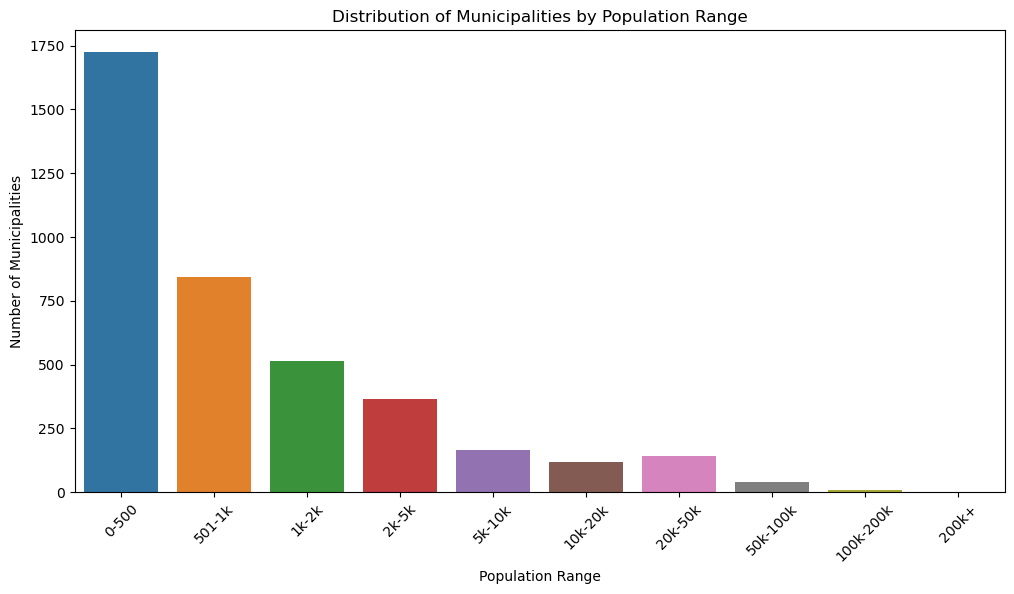

In [158]:

# Define the bins
bins = [0, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, float('inf')]
labels = ['0-500', '501-1k', '1k-2k', '2k-5k', '5k-10k', '10k-20k', '20k-50k', '50k-100k', '100k-200k', "200k+"]

# Create a new column with the binned data
df_stats_communes['population_category'] = pd.cut(df_stats_communes['P21_POP'], bins=bins, labels=labels, right=False)

# Count the municipalities in each bin
#population_distribution = pd.DataFrame(df_stats_communes['population_category'].value_counts().sort_index())
population_distribution = df_stats_communes['population_category'].value_counts().sort_index()


# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x=population_distribution.index, y=population_distribution.values)

plt.title('Distribution of Municipalities by Population Range')
plt.xlabel('Population Range')
plt.ylabel('Number of Municipalities')
plt.xticks(rotation=45)
plt.show()

#### Scaling

In [159]:
from sklearn.preprocessing import StandardScaler

def scale_data(df, columns_to_scale=[]):

    # Preprocessing
    cols_drop=[
        'CODGEO', 'REG', "P21_POP", "P15_POP", "SUPERF", "P21_MEN",
        "NAIS1520",
        "DECE1520",
        "NAISD22",
        "DECESD22",
        "P21_LOG",
        "P21_RP",
        "P21_RSECOCC",
        "P21_LOGVAC",
        "P21_RP_PROP",
        "NBMENFISC21",
        "P21_EMPLT",
        "P21_EMPLT_SAL",
        "P15_EMPLT",
        "P21_POP1564",
        "P21_CHOM1564",
        "P21_ACT1564",
        "ETTOT21",
        "ETAZ21",
        "ETBE21",
        "ETFZ21",
        "ETGU21",
        "ETGZ21",
        "ETOQ21",
        "ETTEF121",
        "ETTEFP1021",
        "pop_0_29ans",
        "population_category"
    ]
    X = df.drop(cols_drop, axis=1)

    scaler = StandardScaler()
    if len(columns_to_scale)>0:
        X_scaled = scaler.fit_transform(X[columns_to_scale])
    else:
        X_scaled = scaler.fit_transform(X)

    return X_scaled

In [160]:
# scale df selon type d'indicateur et nb habitants
"""liste des indicateurs:
    - Démographie
    - Société
    - Immobilier
    - Economie
"""
type_ind='Démographie' #Démographie, Immobilier
population=1000

bibl_ind=[
    {"field": 'densite_demographique', "alias": "Densité démo.", "dimension": "Démographie"},
    {"field": 'tx_evol_demographique', "alias": "% évol. démo.", "dimension": "Démographie"},
    {"field": "ind_jeunesse", "alias": "Ind. de jeunesse", "dimension": "Démographie"},
    {"field": "tx_scolarisation", "alias": "Tx de scolarisation", "dimension": "Démographie"},
    {"field": "tx_pop_sans_diplome", "alias": "% pop sans diplome", "dimension": "Démographie"},
    {"field": "tx_pop_bac+2_ou_+", "alias": "% pop bac+2 ou +", "dimension": "Démographie"},    
    {"field": 'TP6021', "alias": "Tx pauvreté", "dimension": "Société"},
    {"field": 'MED21', "alias": "Niveau de vie median", "dimension": "Société"},
    {"field": 'tx_chomage', "alias": "Tx chômage", "dimension": "Société"},
    {"field": 'prix_m2_logmts', "alias": "Prix m2 logts.", "dimension": "Immobilier"},
    {"field": '%_evol_nb_ventes_logmts', "alias": "%_evol_nb_ventes_logmts", "dimension": "Immobilier"},
    {"field": '%_evol_prix_m2_logmts', "alias": "%_evol_prix_m2_logmts", "dimension": "Immobilier"},
    {"field": 'tx_vacance_log', "alias": "Tx vacance log.", "dimension": "Immobilier"},
    {"field": 'prix_m2_locaux', "alias": "Prix m2 locaux.", "dimension": "Economie"},
    {"field": '%_evol_nb_ventes_locaux', "alias": "%_evol_nb_ventes_locaux", "dimension": "Economie"},
    {"field": '%_evol_prix_m2_locaux', "alias": "%_evol_prix_m2_locaux", "dimension": "Economie"},
    {"field": "indicateur_dvm", "alias": "Ind. durée vie établ.", "dimension": "Economie"},
    {"field": "%_evol_creations_etabl", "alias": "Ind. créations établ.", "dimension": "Economie"},
    {"field": 'tx_activite', "alias": "Tx activité", "dimension": "Economie"},    
    {"field": 'part_emplois_salaries', "alias": "% emplois salariés", "dimension": "Economie"},
    {"field": 'part_emplois_dans_la_commune', "alias": "% emplois dans la commune", "dimension": "Economie"},
    {"field": 'densite_etablissements', "alias": "Densité établ.", "dimension": "Economie"},
    {"field": 'tx_etablissements', "alias": "Tx établ.", "dimension": "Economie"},
    {"field": 'part_Ets_agriculture', "alias": "% établ. agriculture", "dimension": "Economie"},
    {"field": 'part_Ets_industrie', "alias": "% établ. industrie", "dimension": "Economie"},
    {"field": 'part_Ets_construction', "alias": "% établ. construction", "dimension": "Economie"},
    {"field": 'part_Ets_commerce_services', "alias": "% établ. commerce_services", "dimension": "Economie"},
    {"field": 'part_Ets_adm_publique', "alias": "% établ. adm_publique", "dimension": "Economie"},
    {"field": 'part_Ets_1_a_9_salariés', "alias": "% établ. 1_a_9_salariés", "dimension": "Economie"},
    {"field": 'part_Ets_10_salaries_ou_+', "alias": "% établ. 10_salaries_ou_+", "dimension": "Economie"},
]

if type_ind=='all' or type_ind=='':
    inds=[r["field"] for r in bibl_ind]
else:
    inds=[r["field"] for r in bibl_ind if r["dimension"]==type_ind]


df_stats_communes_filtre=df_stats_communes[df_stats_communes['P21_POP']>= population].reset_index().dropna()
X_scaled=scale_data(df_stats_communes_filtre, inds)
X_scaled.shape

(1192, 6)

### Reduction de dimension
Nous filtrons le dset sur les communes de +de 500 habitants

##### PCA pour déterminer le nb de composantes nécessaires pour expliquer la variance du dataset

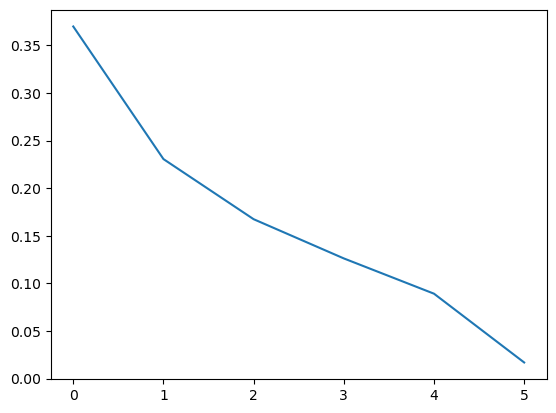

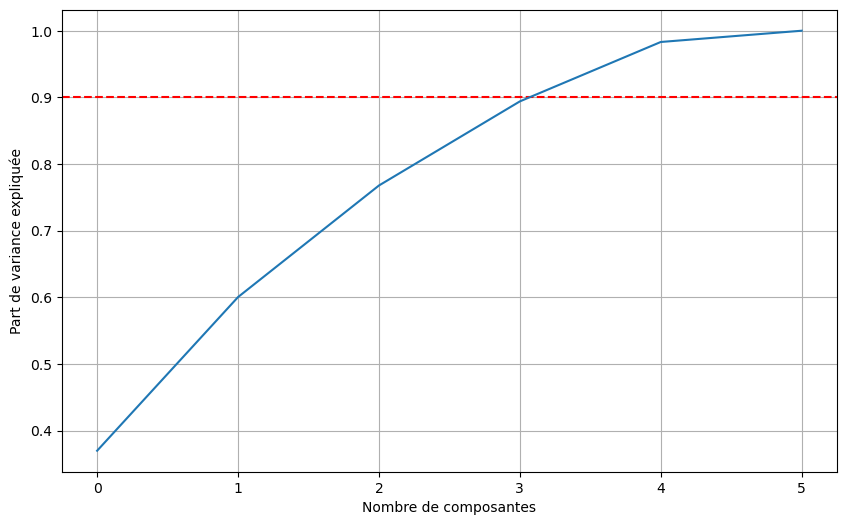

In [161]:

# PCA
#k
pca=PCA()
#l
prj= pca.fit_transform(X_scaled)

#m
plt.figure()
#plt.xlim(0,100)
plt.plot(pca.explained_variance_ratio_)

#n
plt.figure(figsize=(10,6))
#plt.xlim(0,100)
plt.xlabel('Nombre de composantes')
plt.ylabel('Part de variance expliquée')
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());
plt.grid()

* 11 composantes peuvent expliquer 90% de la variance

#### Déterminer le nb optimal de clusters: elbow method

* Implementation scipy.cdist

In [162]:
# Importation de la fonction cdist du package scipy.spatial.distance
from scipy.spatial.distance import cdist




def get_kmeans_optimal_clusters(X, verbose=False):
    # Liste des nombres de clusters
    range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]  

    # Initialisation de la liste de distorsions
    distorsions = []

    # Calcul des distorsions pour les différents modèles
    for n_clusters in range_n_clusters:
        
        # Initialisation d'un cluster ayant un pour nombre de clusters n_clusters
        cluster = KMeans(n_clusters = n_clusters)
        
        # Apprentissage des données suivant le cluster construit ci-dessus
        cluster.fit(X)
        
        # Ajout de la nouvelle distorsion à la liste des données
        distorsions.append(sum(np.min(cdist(X, cluster.cluster_centers_, 'euclidean'), axis=1)) / np.size(X, axis = 0))

    df_dist=pd.DataFrame( data={"range_n_clusters": range_n_clusters, "distorsions": distorsions})
    
    if verbose:
        print('distorsions by n_clusters;')
        pd.DataFrame(data={"clusters": range_n_clusters, "distortion":distorsions})

        plt.plot(range_n_clusters, distorsions, 'gx-')
        plt.xlabel('Nombre de Clusters K')
        plt.ylabel('Distorsion SSW/(SSW+SSB)')
        plt.title('Méthode du coude affichant le nombre de clusters optimal')
        plt.grid()
        plt.show()

        
        display(df_dist)

    df_dist['diff'] = df_dist['distorsions'].diff().abs()

    # Find the index of the maximum change (which indicates the elbow)
    elbow_index = df_dist['diff'].idxmax()
    optimal_clusters = df_dist['range_n_clusters'][elbow_index]

    return optimal_clusters




In [163]:
def get_df_from_lower_dimension(X, df_source, cols, clusters):
    df=pd.DataFrame(data=X, columns=cols)
    df["region"]= df_source["REG"].map({"11": "IDF", '28': "Normandie"})
    df["CODGEO"]= df_source["CODGEO"]
    df["dep"]= df["region"]+"-"+ df_source["CODGEO"].str[:2]
    df['clusters'] = clusters.astype(str)
    df=df.merge(df_source, on='CODGEO', how='inner')
    df=df.merge(df_communes, left_on='CODGEO', right_on='COM', how='inner').drop(
        columns=[
            'TYPECOM', 'COM',
            'REG_y', 'DEP', 'CTCD', 'ARR', 'TNCC', 'NCC', 'NCCENR',
            'CAN', 'COMPARENT'
        ]
    ).rename(columns={'LIBELLE': 'libcom'})

    return df

#### Déterminer le nb optimal de clusters: grid search

In [168]:
def get_best_params_MiniBatchKMeans(X):
    # Define the scoring function based on silhouette score
    def silhouette_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        return silhouette_score(X, labels)

    # Define the parameter grid specifically for MiniBatchKMeans
    param_grid = {
        'n_clusters': [3,4,5,6,7,8,9,10, 11,12,13,14,15],# Fixed based on elbow method
        'init': ['k-means++', 'random'],
        'n_init': [10, 20],  # Number of initializations
        'max_iter': [300, 600],  # Maximum iterations for a single run
        'tol': [1e-4, 1e-3],  # Tolerance for convergence
        'batch_size': [50, 100, 250, 500],  # Size of the mini-batches
        'max_no_improvement': [10, 20, 50]  # Early stopping criteria
    }

    # Set up the MiniBatchKMeans model
    mini_batch_kmeans = MiniBatchKMeans(random_state=42)

    # Set up the grid search with cross-validation and parallelization
    grid_search = GridSearchCV(
        estimator=mini_batch_kmeans,
        param_grid=param_grid,
        #scoring=make_scorer(silhouette_scorer),
        cv=3,  # 3-fold cross-validation
        n_jobs=-1  # Utilize all available CPUs for parallel processing
    )

    # Fit the grid search model
    grid_search.fit(X)

    # Output the best parameters and best score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best silhouette score: {grid_search.best_score_}")

    return {"best_params": grid_search.best_params_, "best_estimator": grid_search.best_estimator_, }

In [165]:
n_clusters_pca=None

In [ ]:
n_components=3
clustering_model="mini_batch_kmeans"
pca_cols=[]
for i in range(0,n_components):
    pca_cols.append(f'axe_{i}')

# PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


# K-Means
if clustering_model=="kmeans":
    if n_clusters_pca==None:
        n_clusters_pca=get_kmeans_optimal_clusters(X_pca,)

    kmeans = KMeans(n_clusters=n_clusters_pca, random_state=42)
    clusters = kmeans.fit_predict(X_pca)
elif clustering_model=='mini_batch_kmeans':
    grid_miniKmeans= get_best_params_MiniBatchKMeans(X_pca,)
    n_clusters_pca=grid_miniKmeans["best_params"]["n_clusters"]
    clusters = grid_miniKmeans["best_estimator"].fit_predict(X_pca)

# Adding cluster labels to the original data
#df_stats_communes['clusters'] = kmeans_clusters.astype(str)


# add codgeo
#df_pca=get_df_from_lower_dimension(X_pca, pca_cols, kmeans_clusters)


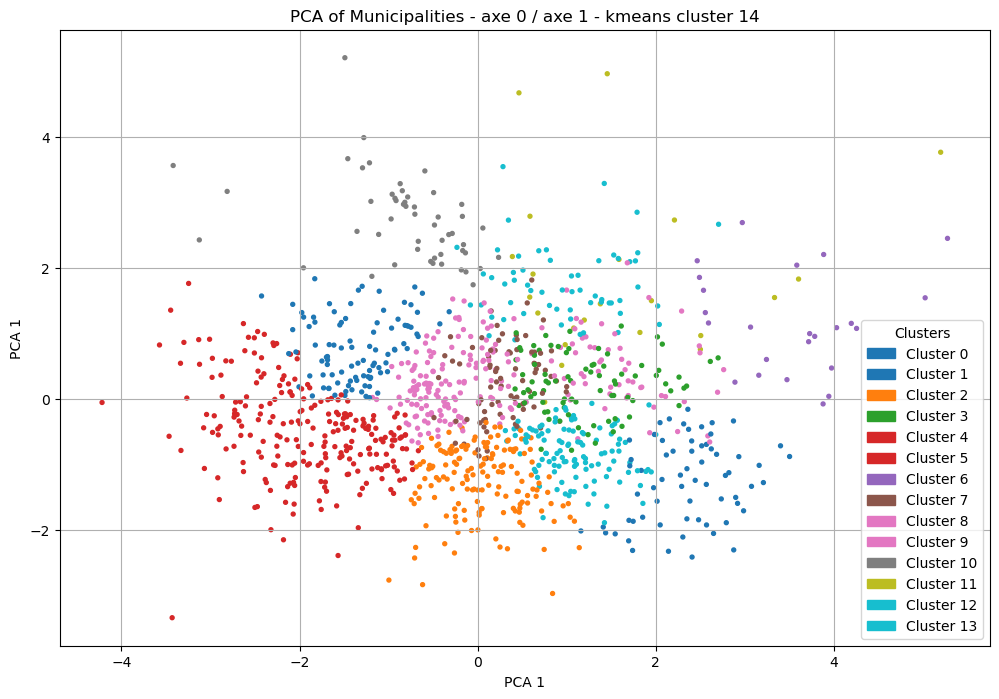

In [167]:
#for i in range(1, n_components):
i=1

import matplotlib.patches as mpatches

# Assuming kmeans_clusters is your cluster labels and n_clusters_pca is the number of clusters
unique_clusters = np.unique(clusters)

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, i], c=clusters, cmap='tab10', s=8)

# Create legend handles
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(cluster)), label=f'Cluster {cluster}') for cluster in unique_clusters]

# Add legend to the plot
plt.legend(handles=handles, title="Clusters")

# Add labels and title
plt.xlabel('PCA 1')
plt.ylabel(f'PCA {i}')
plt.grid()
plt.title(f'PCA of Municipalities - axe 0 / axe {i} - kmeans cluster {n_clusters_pca}')

# Display the plot
plt.show()

# scatter_plot = px.scatter(
#     df_pca, x='axe_0', y='axe_1', 
#     color=kmeans_clusters.astype(str),
#     hover_name='CODGEO',
#     title='',    
# )
# scatter_plot.update_layout(height=720,dragmode='select')
# scatter_plot.update_traces(marker_size=10)
# scatter_plot.show()
